# Leaf Disease Classification – ResNet50 (Evaluation Notebook)

This notebook:
- Loads the plant leaf disease dataset from Google Drive
- Loads a pre-trained ResNet50 model (fine-tuned previously)
- Evaluates the model (accuracy, F1, classification report)
- Generates visualizations (sample images, confusion matrix, per-class F1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import pathlib
import numpy as np
import matplotlib.pyplot as plt

# Dataset and checkpoint locations in Google Drive
DATA_DIR = pathlib.Path(
    "/content/drive/MyDrive/plant_disease_project/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation"
)

CHECKPOINT_PATH = "/content/drive/MyDrive/plant_disease_project/resnet50_best.h5"

print("DATA_DIR:", DATA_DIR)
print("Example subfolders under DATA_DIR:")
for p in list(DATA_DIR.glob("*"))[:10]:
    print(" -", p.name)


Mounted at /content/drive
DATA_DIR: /content/drive/MyDrive/plant_disease_project/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation
Example subfolders under DATA_DIR:
 - Corn___Cercospora_leaf_spot Gray_leaf_spot
 - Corn___Common_rust
 - Corn___healthy
 - Corn___Northern_Leaf_Blight
 - Grape___Black_rot
 - Grape___Esca_(Black_Measles)
 - Grape___healthy
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 - Orange___Haunglongbing_(Citrus_greening)
 - Peach___Bacterial_spot


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

def load_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    AUTOTUNE = tf.data.AUTOTUNE

    def prepare(ds, shuffle=False):
        if shuffle:
            ds = ds.shuffle(256, seed=SEED)
        return ds.prefetch(AUTOTUNE)

    train_ds_prep = prepare(train_ds, shuffle=True)
    val_ds_prep = prepare(val_ds, shuffle=False)

    class_names = train_ds.class_names
    return train_ds_prep, val_ds_prep, class_names


In [ ]:
train_ds_prep, val_ds_prep, class_names = load_datasets()
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("First 10 classes:", class_names[:10])


Found 55448 files belonging to 39 classes.
Using 44359 files for training.
Found 55448 files belonging to 39 classes.
Using 11089 files for validation.
Number of classes: 39
First 10 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust']


In [ ]:
def build_resnet50_model(num_classes):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])

    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = False  # we are only using the already fine-tuned head

    inputs = Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
model = build_resnet50_model(num_classes)

try:
    model.load_weights(CHECKPOINT_PATH)
    print("Loaded trained weights from:", CHECKPOINT_PATH)
except Exception as e:
    print("Could not load weights:", e)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded trained weights from: /content/drive/MyDrive/plant_disease_project/resnet50_best.h5


In [ ]:
val_loss, val_acc = model.evaluate(val_ds_prep)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)


694/694 ━━━━━━━━━━━━━━━━━━━━ 1315s 2s/step - accuracy: 0.9704 - loss: 0.1021
Validation loss: 0.09882674366235733
Validation accuracy: 0.9704211354255676


In [ ]:
!pip install scikit-learn pandas --quiet

from sklearn.metrics import classification_report, f1_score, confusion_matrix
import pandas as pd


In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds_prep:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [ ]:
from sklearn.metrics import classification_report, f1_score

print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

report_str = classification_report(y_true, y_pred, target_names=class_names)
print(report_str)


Macro F1: 0.9621796888060208
Weighted F1: 0.9702619322261986
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.99      1.00       126
                            Apple___Black_rot       0.99      1.00      1.00       132
                     Apple___Cedar_apple_rust       0.93      1.00      0.96        55
                              Apple___healthy       0.99      1.00      1.00       330
                    Background_without_leaves       1.00      0.99      1.00       219
                          Blueberry___healthy       1.00      1.00      1.00       332
                      Cherry___Powdery_mildew       1.00      0.97      0.98       209
                             Cherry___healthy       0.99      1.00      1.00       148
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.72      0.81       104
                           Corn___Common_rust       0.99      1.00  

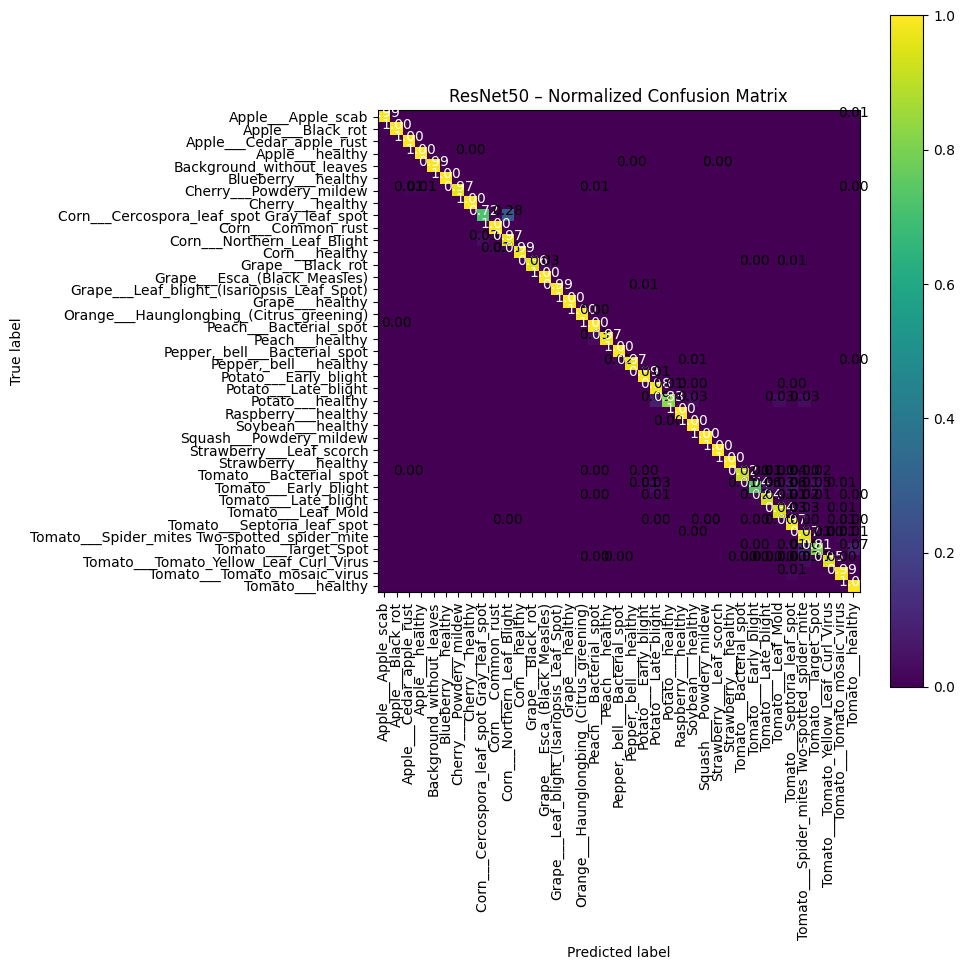

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm_display = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    else:
        cm_display = cm

    plt.figure(figsize=(10, 10))
    plt.imshow(cm_display, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm_display.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            value = cm_display[i, j]
            if value > 0:
                plt.text(j, i, format(value, fmt),
                         ha="center",
                         color="white" if value > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names, normalize=True, title='ResNet50 – Normalized Confusion Matrix')
plt.show()


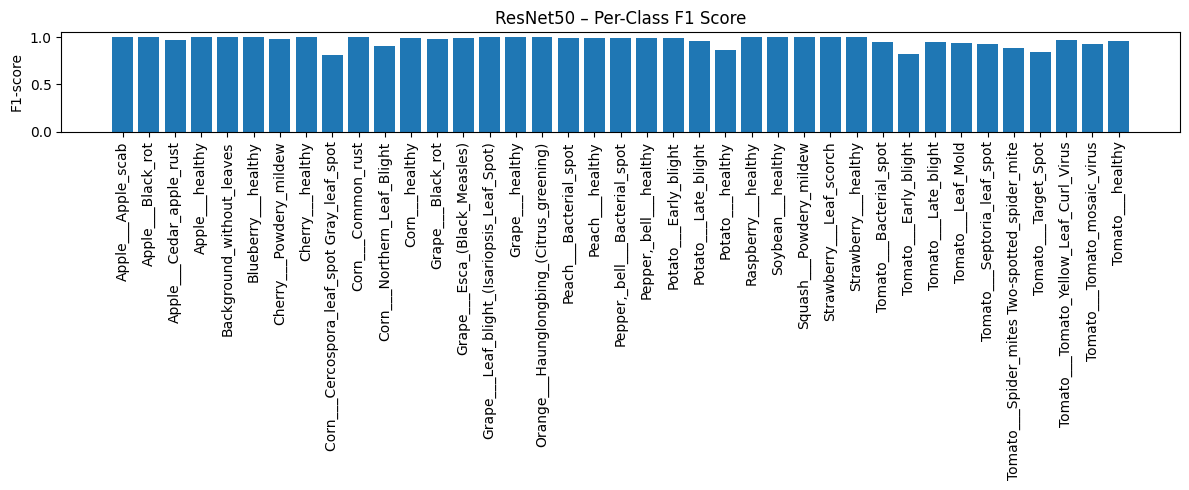

In [ ]:
import pandas as pd

report_dict = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()

# Only actual class rows
class_rows = df_report.iloc[:len(class_names)]

plt.figure(figsize=(12, 5))
plt.bar(range(len(class_names)), class_rows['f1-score'])
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.ylabel('F1-score')
plt.title('ResNet50 – Per-Class F1 Score')
plt.tight_layout()
plt.show()


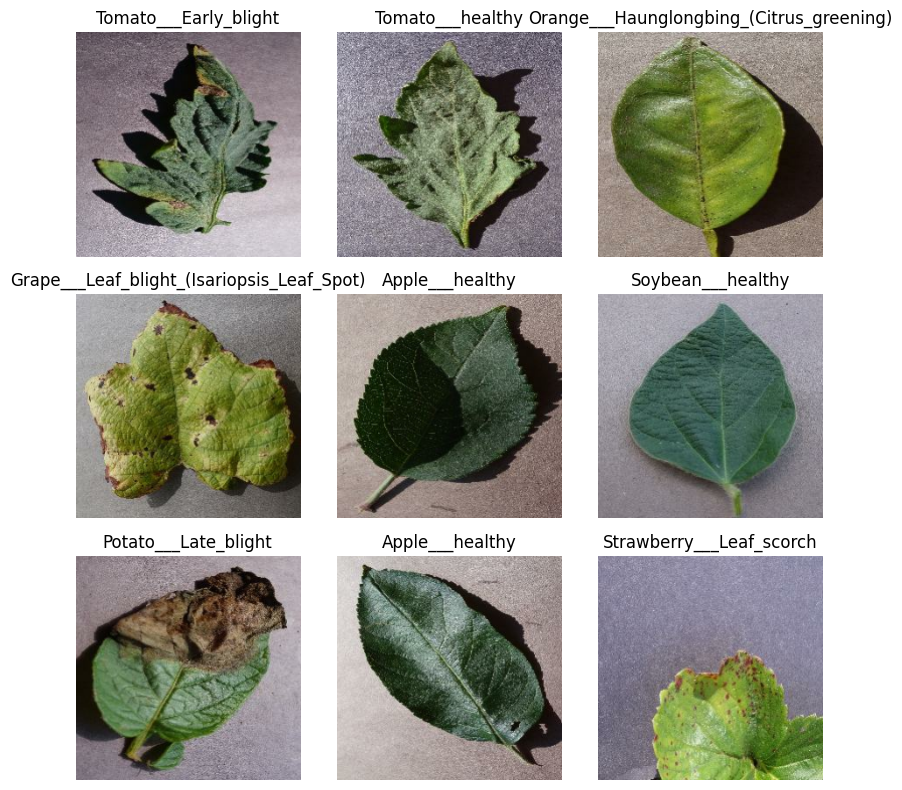

In [ ]:
images, labels = next(iter(train_ds_prep))

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()
